# A/B Test 

Define whether difference in average payment amount in groups A and B is statistically significant. Justify your answer

## Libreries

In [32]:
#Processing data
import pandas as pd
import numpy as np

#Graphics
import matplotlib.pyplot as plt
import seaborn as sb

#Models
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")


## Data

In [33]:
data = pd.read_csv('/Users/user/Desktop/Sandsoft_test/Business Data Scientist - Test/ab_test.csv')
data.head()

,group_A,group_B
0,21,21
1,18,12
2,12,8
3,8,22
4,20,5


The dataset is composed for two different group of payment amounts, and in this job it will be assumed that they are independents. There are a total of 89 records for both groups.

First of all it's important to check whether the information is complete. So, let's proced to check if there are null values in the dataset

In [34]:
data.isnull().sum()

group_A    0
group_B    0
dtype: int64

As we can see there are no null values.

It is important to check the distribution of the values, because the mean is sensitive to outliers and also, the tests assume that the groups are normally distributed. This is easily visible by plotting the distribution of values for each group.

<AxesSubplot:xlabel='group_B', ylabel='Density'>

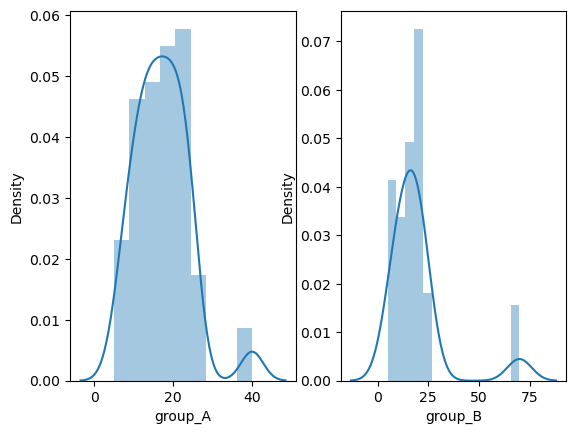

<Figure size 600x400 with 0 Axes>

In [35]:
figure,axis = plt.subplots(nrows = 1, ncols = 2)
figure = plt.figure(figsize=(6,4))

sb.distplot(data.group_A, ax=axis[0])
sb.distplot(data.group_B, ax=axis[1])

In the graphics is visible the presence of high values (outliers) that may distort the results of the hypothesis test.

The outliers are also visible through a box plot.

Text(0.5, 0, 'Group')

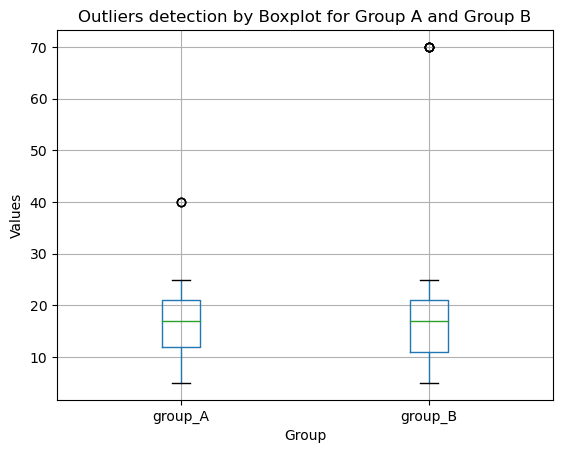

In [36]:
data.boxplot()

plt.title('Outliers detection by Boxplot for Group A and Group B')
plt.ylabel('Values')
plt.xlabel('Group')


It is necessary to remove them from the dataset to perform the hypothesis test and obtain reliable information.

The groups will be treated separately and the outliers will be eliminated by the boxplot method, which consists of eliminating the values outside the range of the boxplot.

In [37]:
#GROUP A
q1 = np.percentile(data['group_A'], 25)
q3 = np.percentile(data['group_A'], 75)
iqr = q3-q1

minimum = max(q1-(1.5*iqr),0)
minimum

maximum = q3+1.5*iqr
maximum

group_A = data[(data.group_A > minimum) & (data.group_A < maximum)]['group_A']

print(f'There are {len(data.group_A)-len(group_A) :1.0f}' + ' records removed from the group A')

There are 3 records removed from the group A


In [38]:
#GROUP B
q1 = np.percentile(data['group_B'], 25)
q3 = np.percentile(data['group_B'], 75)
iqr = q3-q1

minimum = max(q1-(1.5*iqr),0)
minimum

maximum = q3+1.5*iqr
maximum

group_B = data[(data.group_B > minimum) & (data.group_B < maximum)]['group_B']

print(f'There are {len(data.group_B)-len(group_B) :1.0f}' + ' records removed from the group B')

There are 6 records removed from the group B


Now we can redraw the boxplots and check if outliers have been removed.

<AxesSubplot:>

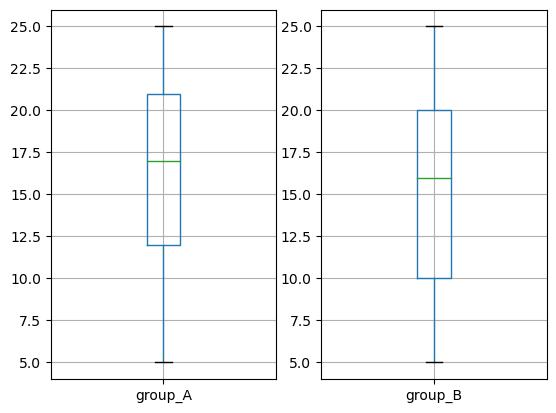

<Figure size 600x400 with 0 Axes>

In [39]:
figure,axis = plt.subplots(nrows = 1, ncols = 2)
figure = plt.figure(figsize=(6,4))

pd.DataFrame(group_A).boxplot(ax=axis[0])
pd.DataFrame(group_B).boxplot(ax=axis[1])


Also let's redraw the density function for each group 

<AxesSubplot:xlabel='group_B', ylabel='Density'>

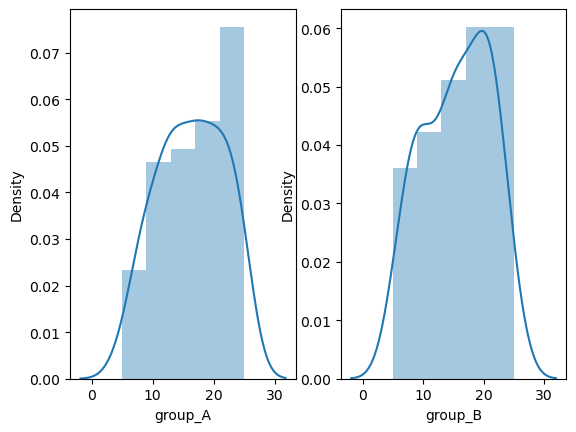

<Figure size 600x400 with 0 Axes>

In [40]:
figure,axis = plt.subplots(nrows = 1, ncols = 2)
figure = plt.figure(figsize=(6,4))

sb.distplot(group_A, ax=axis[0])
sb.distplot(group_B, ax=axis[1])

The density function for both groups now looks as a normal distribution.

Before performing the hypothesis test, the density function for group A and B are plotted in the same table to compare them graphically.

Text(0.5, 1.0, 'Density Function')

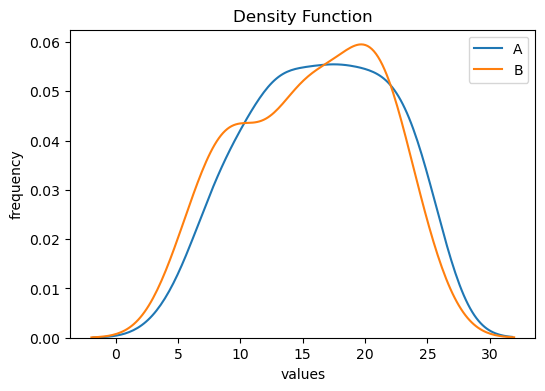

In [41]:
plt.figure(figsize=(6,4))

sb.kdeplot(data=group_A)
sb.kdeplot(data=group_B)
plt.legend(['A','B'])
plt.xlabel('values')
plt.ylabel('frequency')
plt.title('Density Function')

A priori we can think that there is no significant difference between both groups. The 'describe' function from Pandas gives a bit more information about the groups:

In [42]:
pd.DataFrame({'group_A' :group_A.describe(),'group_B' :group_B.describe()}).round(2)

,group_A,group_B
count,86.00,83.00
mean,16.36,15.58
std,5.52,5.61
min,5.00,5.00
25%,12.00,10.00
50%,17.00,16.00
75%,21.00,20.00
max,25.00,25.00


The payment amount mean of the Group_A is a bit higher than the Group_B and also, has a bit less dispersion. 

## Hypothesis Test

Through a hypothesis test we can infer whether there is a significant difference in the average payment amount of groups A and B, contrasting the null hypothesis that there is no difference.

        H0: AV_A is equal to AV_B
        H1: AV_A is different to AV_B
        
Where:

    - AV_A: The mean population of payment amount for the Group A
    - AV_B: The mean population of payment amount for the Group B

        

### Metric

Average payment amount

### Assumptions

    - The values of the samples are independent  
    - The value of the samples came randomly from a normal distribution
    - The variance of both groups are equals (will be checked later)
    - Significance = 5%
    


### Hypothesis test to infer if both groups have the same variance ratio

    H0: var_A is equal to var_B
    H1: var_A is different to var_B
    
    - var_A: The variance population payment amount for the Group A
    - var_B: The variance population payment amount for the Group B
    
    
    
 
    
The test procedure consists of calculating the rejection zone and checking if the F statistic obtained by the sample is outside or inside the critical limits. 
Decision rule: 
- If the F statistic is inside the critical limits, there is no statistical evidence to reject the null hypothesis. In this case, the variance of the Group A is equal to the group B.
- If the F statistic is outside the critical limits, there is statistical evidence to reject the null hypothesis. so, the variance for both groups are different.

Statistic and critical limits:
- The F statistic is calculated by divide the highest variance of the groups by the lowest one.
- The distribution function is an F distribution with v1 and v2 degrees of freedom, where 'v1' is the size of the group with the highest variance and 'v2' the size of the group with the lowest one.
- The critical limits are given by the percentiles 2.5% and 97.5% of the F distribution (since is a two-sided test).


In [43]:
#Variance for each group
var_a = group_A.var()
var_b = group_B.var()

#The number of registers bor both groups
n_a = len(group_A)
n_b = len(group_B)

#statistic F
f_statistic = max(var_a,var_b)/min(var_a,var_b)

#degrees of freedom where v1 is the size of the group with higher variance, and v2 the lowest one.
v1 = np.where(var_a>var_b,n_a,n_b)
v2 = np.where(var_a>var_b,n_b,n_a)

#F distrivution with v1 and v2 degrees of freedom
dist_f =  stats.f(dfn = v1, dfd = v2)

#The upper bound is the 97.5% percentile value of the distribution function
lower_bound_f = dist_f.ppf(q = 0.975)

#The lower bound is the 2.5% percentile value of the distribution function
upper_bound_f = dist_f.ppf(q = 0.025)

The result of the test will be ploted in the next graphic:

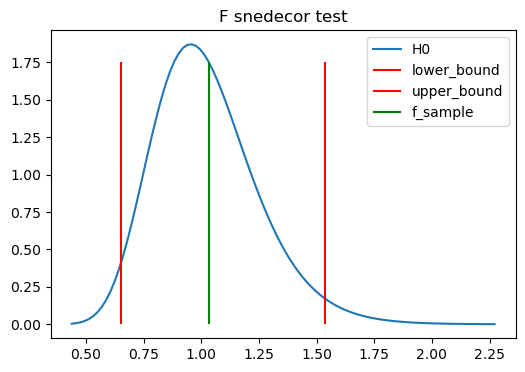

Statistic F:  1.0320
Lower limit:  1.5351
Upper limit:  0.6504


In [44]:
#Generation of 100 values coming from the F distribution
points = np.linspace(dist_f.ppf(0.0001),dist_f.ppf(0.9999),100)

#The density of the genereted points 
density = dist_f.pdf(points)

#Plot of the distribution which represent the null hypothesis, delimited by the critical values in red colour and the F statistic in green colour
plt.figure(figsize=(6,4))
plt.plot(points,density)
plt.vlines(ymin=0, ymax=1.75, x=lower_bound_f,  colors='r')
plt.vlines(ymin=0, ymax=1.75, x=upper_bound_f,  colors='r')
plt.vlines(ymin=0, ymax=1.75, x=f_statistic,  colors='g')
plt.legend(['H0','lower_bound','upper_bound','f_sample'])
plt.title("F snedecor test")
plt.show()

print(f'Statistic F: {f_statistic: 0.4f}')
print(f'Lower limit: {lower_bound_f: 0.4f}')
print(f'Upper limit: {upper_bound_f: 0.4f}')

For this Hypothesis test, as the sample F statistic obtained by the variances of group A and B is 1.032 and is located within the critical values (1.53 and 0.65, respectively), it can be statistically concluded that the variance is the same for both groups , with a risk of 5% of being wrong.

### Hypothesis test to infer if both groups have the same mean

    H0: mean_A is equal to mean_B
    H1: mean_A is different to mean_B
    
    - mean_A: The mean population payment amount for the Group A
    - mean_B: The mean population payment amount for the Group B
    
    
    
The test procedure consists of calculating the rejection zone and checking if the T statistic obtained by the sample is outside or inside the critical limits. 
Decision rule: 
- If the T statistic is inside the critical limits, there is no statistical evidence to reject the null hypothesis. In this case, the mean of the Group A is equal to the group B.
- If the T statistic is outside the critical limits, there is statistical evidence to reject the null hypothesis. so, the mean for both groups are different.

Statistic and critical limits:
- The T statistic is calculated by the ttest_ind function in scipy
- The distribution function is a T-Student distribution with n1+n2-2 degrees of freedom, where 'n1' is the size of the group A and 'n2' the size of the group B.
- The critical limits are given by the percentiles 2.5% and 97.5% of the T-Student distribution (since is a two-sided test).

In [45]:
from scipy.stats import ttest_ind

#t statistic
t_statistic = ttest_ind(group_A,group_B, equal_var=True).statistic

#Degrees of freedom
df = len(group_A)+len(group_B)-2

#T-Student distribution with 167 degrees of freedom
dist_t =  stats.t(df = df)

lower_bound_t = dist_t.ppf (q = 0.975)
upper_bound_t = dist_t.ppf (q = 0.025)


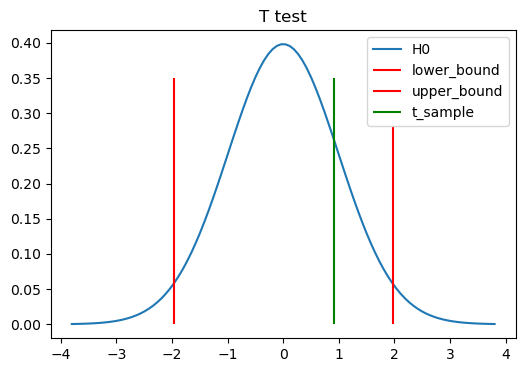

T Statistic:  0.9130
Lower limit:  1.9743
Upper limit: -1.9743


In [46]:
#Generation of 100 values coming from the T-Student distribution
points = np.linspace(dist_t.ppf(0.0001),dist_t.ppf(0.9999),100)

#The density of the genereted points 
density = dist_t.pdf(points)

#Plot of the distribution which represent the null hypothesis, delimited by the critical values in red colour and the T statistic in green colour.
plt.figure(figsize=(6,4))
plt.plot(points,density)
plt.vlines(ymin=0, ymax=0.28, x=lower_bound_t,  colors='r')
plt.vlines(ymin=0, ymax=0.35, x=upper_bound_t,  colors='r')
plt.vlines(ymin=0, ymax=0.35, x=t_statistic,  colors='g')
plt.legend(['H0','lower_bound','upper_bound','t_sample'])
plt.title("T test")
plt.show()

print(f'T Statistic: {t_statistic: 0.4f}')
print(f'Lower limit: {lower_bound_t: 0.4f}')
print(f'Upper limit: {upper_bound_t: 0.4f}')

For this Hypothesis test, as the sample T statistic obtained by the sample is 0.91 and is located within the critical values (1.97 and -1.97, respectively), it can be statistically concluded that the mean is the same for both groups, with a 5% risk of making a false decision. 

## Conclusion

After performing the hypothesis test to contrast the population means of groups A and B, and under the indicated assumptions, we can conclude that there is significant evidence to establish that the mean of the amount payments is the same between the group A and B, with a significance level of 95%